In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

In [251]:
SP = pd.read_csv('data/VIX.csv').dropna()
SP.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0


In [252]:
# SP.rename(columns={'GOLDAMGBD228NLBM': 'Close'}, inplace=True)
# SP.Close = SP.Close.apply(pd.to_numeric, errors='coerce')
# SP.Close = SP.Close.fillna(method='ffill')

In [253]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7733 entries, 0 to 7732
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7733 non-null   object 
 1   Open       7733 non-null   float64
 2   High       7733 non-null   float64
 3   Low        7733 non-null   float64
 4   Close      7733 non-null   float64
 5   Adj Close  7733 non-null   float64
 6   Volume     7733 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 483.3+ KB


In [254]:
i = 1
f = [1, 2]

for i in range(15):
    i = f[-1] + f[-2]
    f.append(i)
    
print(f)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]


In [255]:
df = []

for i in range(5000):
    period_pred = 30
    chnd = (SP.Close.iloc[-2 - i - period_pred]/SP.Close.iloc[-1 - i] - 1)*100
    row = []
    if chnd < -10:
        row.append(1)
    else:
        row.append(0)
    for j in (2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610):
        row.append(SP.Close.iloc[-j - i - period_pred])
    df.append(row)
    

In [256]:
df = pd.DataFrame(df)
df.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,24.74,25.840000,24.320000,25.680000,27.290001,31.780001,27.570000,27.570000,61.590000,12.47,19.320000,17.660000,15.800000
1,1,25.84,26.080000,24.840000,28.000000,29.260000,34.730000,27.570000,27.980000,66.040001,13.78,19.870001,19.129999,16.490000
2,1,26.08,24.320000,24.459999,27.760000,28.080000,32.220001,25.809999,31.440001,72.000000,14.82,16.680000,18.870001,18.719999
3,1,24.32,24.840000,25.680000,29.520000,29.430000,33.840000,24.520000,34.119999,76.449997,13.43,15.800000,17.420000,20.020000
4,0,24.84,24.459999,28.000000,32.189999,27.940001,31.370001,25.809999,33.610001,75.910004,12.65,17.500000,18.889999,20.600000


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5000 non-null   int64  
 1   1       5000 non-null   float64
 2   2       5000 non-null   float64
 3   3       5000 non-null   float64
 4   4       5000 non-null   float64
 5   5       5000 non-null   float64
 6   6       5000 non-null   float64
 7   7       5000 non-null   float64
 8   8       5000 non-null   float64
 9   9       5000 non-null   float64
 10  10      5000 non-null   float64
 11  11      5000 non-null   float64
 12  12      5000 non-null   float64
 13  13      5000 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 547.0 KB


In [258]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

In [259]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['0'], 1), df['0'], random_state=0)

In [260]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

continuous_columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

In [261]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# preds = rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
fscore = (2 * precision/50 * recall) / (precision/50 + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
print(roc_auc)

Best Threshold=0.283, F-Score=0.625, Precision=0.510, Recall=0.806
Best Threshold=0.641, F-Score=0.030, Precision=0.860, Recall=0.132
0.8288282744282744


In [262]:
y_test.value_counts(normalize=True)

0    0.74
1    0.26
Name: 0, dtype: float64

In [271]:
preds = pipeline.predict_proba(df['0'])[:, 1]

KeyError: "None of [Index(['1'], dtype='object')] are in the [index]"

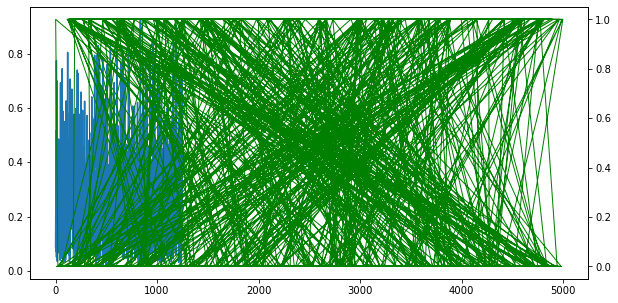

In [269]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
lns1 = ax.plot(preds)
ax2 = ax.twinx()
lns2 = ax2.plot(y_test, linewidth=1, c='g', label='y')
lns = lns1+lns2
plt.show()